### CLASSIFICATION

In [10]:
# открываем clean_df с part_3
import pandas as pd
clean_df= pd.read_csv('part_3.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(clean_df.shape)
clean_df['checked_churn'].value_counts()

(2053, 31)


0    1447
1     606
Name: checked_churn, dtype: int64

In [11]:
clean_df.shape

(2053, 31)

In [12]:
# открываем feature_df с part_3

feature_df= pd.read_csv('part_2_feature_df.csv')
feature_df.drop('Unnamed: 0',inplace = True,axis = 1)
print(feature_df.shape)
feature_df.head(1)

(2053, 3455)


,able,able enjoy,able find,able get,able make,able resolve,able use,able watch,abo,absolute,...,zip code,zone,location_proba,r,f,m,sin_time,cos_time,text_len,topic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.059912,3,3,3,-0.009381,0.999956,54,17


In [13]:
from scipy.stats.stats import pearsonr
cor = dict()
for i in feature_df.columns:
    cor[i] = pearsonr(feature_df[i],clean_df['checked_churn'])[0]
for k,v in cor.items():
    if abs(v)>0.3:
        print(k,v)

text_len -0.7593952523723513


In [14]:
# print(pearsonr(feature_df['topic'],clean_df['checked_churn']))

In [15]:
# checked_churn = list(clean_df['checked_churn'])
# feature_df['checked_churn'] = checked_churn
# feature_df['checked_churn'].value_counts()

In [16]:
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [17]:
# делааем split 


train_x, valid_x, train_y, valid_y = \
    train_test_split(feature_df, clean_df['checked_churn'], \
    test_size=0.2, random_state=45)

In [18]:
# разбивка у train и valid +- одинаковая
print(train_y.value_counts()/train_y.shape[0])
print(valid_y.value_counts()/valid_y.shape[0])
print(len(train_x))
print(len(valid_x))

0    0.704629
1    0.295371
Name: checked_churn, dtype: float64
0    0.705596
1    0.294404
Name: checked_churn, dtype: float64
1642
411


In [19]:
# объявим словарь, куда будем собирать roc_auc
r_a = dict()

###   наивный байес

In [20]:
# оставим только TF-IDF для наивного Байеса

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# благодаря параметру max_features мы оставляем 80% самых выжных фичей
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features = int(0.8 * 4309))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)


feature_names = tf_idf_vect.get_feature_names()
nb_tf_idf = pd.DataFrame(final_tf_idf.toarray(), columns = feature_names)
nb_tf_idf.shape

(2053, 3447)

In [21]:
train_tfidf_x, valid_tfidf_x, train_tfidf_y, valid_tfidf_y = \
    train_test_split(nb_tf_idf, clean_df['checked_churn'], \
    test_size=0.2, random_state=110)

In [22]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_tfidf_x,train_tfidf_y)
y_pred_nb =nb.predict(valid_tfidf_x)
print('для наивного Байеса', roc_auc_score(valid_tfidf_y, y_pred_nb))
r_a['NB'] = roc_auc_score(valid_tfidf_y, y_pred_nb)

для наивного Байеса 0.5388857224280422


###  логистическая регрессия 

In [23]:

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 10)
lr.fit(train_x,train_y)
y_pred_lr =lr.predict(valid_x)

print('для логистической регрессии', roc_auc_score(valid_y, y_pred_lr))
r_a['lr'] = roc_auc_score(valid_y, y_pred_lr)

для логистической регрессии 0.7950840695354803


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
# Решётка для перебора параметра 
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
lr = LogisticRegression(max_iter = 10)
grid_cv_lr = GridSearchCV(lr, param_grid, cv = 5)
grid_cv_lr.fit(train_x, train_y)

print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# Сделали прогнозы
y_pred_lr_grid = grid_cv_lr.predict(valid_x)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Лучшее значение параметра регуляризации: {'C': 0.1}


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
print('для логистической регрессии с grid_search', roc_auc_score(valid_y, y_pred_lr_grid))
r_a['gs_lr'] = roc_auc_score(valid_y, y_pred_lr_grid)

для логистической регрессии с grid_search 0.7968082074665148


#### нормирование данных

In [26]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Он сам будет считать максимумы, минимумы и делить! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы, поделил)
scaler.fit(feature_df) 

# Теперь применяем его к нашим данным 
norm_feature_df = pd.DataFrame(scaler.transform(feature_df),columns =list(feature_df.columns) )
norm_feature_df.shape

(2053, 3455)

In [27]:
norm_train_x, norm_valid_x, norm_train_y, norm_valid_y = \
    train_test_split(norm_feature_df, clean_df['checked_churn'], \
    test_size=0.1, random_state=45)

In [28]:
norm_valid_y.shape

(206,)

In [29]:
norm_lr = LogisticRegression(max_iter = 10,C=0.05)
norm_lr.fit(norm_train_x,norm_train_y)
norm_y_pred_lr =norm_lr.predict(norm_valid_x)

print('для логистической регрессии с нормированеми данными', roc_auc_score(norm_valid_y, norm_y_pred_lr))
r_a['norm_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr)

для логистической регрессии с нормированеми данными 0.8206502107164358


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
# Решётка для перебора параметра 
# param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}
# norm_lr = LogisticRegression(max_iter = 10)
# grid_cv_lr = GridSearchCV(norm_lr, param_grid, cv = 10)
# grid_cv_lr.fit(norm_train_x, norm_train_y)

# print('Лучшее значение параметра регуляризации:', grid_cv_lr.best_params_)

# # Сделали прогнозы
# norm_y_pred_lr_grid = grid_cv_lr.predict(norm_valid_x)


In [31]:
# print('для логистической регрессии с grid_search и нормированием', roc_auc_score(norm_valid_y, norm_y_pred_lr_grid))
# r_a['norm__gs_lr'] = roc_auc_score(norm_valid_y, norm_y_pred_lr_grid)

### Решающее дерево

In [60]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,max_depth = 23)
rnd_clf.fit(train_x, train_y)

pred_rf = rnd_clf.predict(valid_x)
print('для решающего дерева', roc_auc_score(valid_y, pred_rf))
r_a['DT'] = roc_auc_score(valid_y, pred_rf)


для решающего дерева 0.8598318609290395


In [62]:
roc_auc_score(valid_y, pred_rf)

0.8598318609290395

In [33]:
roc_auc_score(train_y,rnd_clf.predict(train_x))

0.9474903990947081

In [34]:
# from sklearn.model_selection import cross_validate,cross_val_score # подгрузили модель

# model = RandomForestClassifier(n_estimators=200, max_depth = 20,random_state=42)
# scores = cross_val_score(model,feature_df,clean_df['checked_churn'],cv = 10,scoring = ('roc_auc'))
# scores

### XGB

In [35]:
# import xgboost as xgb
# x_train,x_test = train_test_split(feature_df,test_size=0.1, random_state=12)
# y_train,y_test = train_test_split(clean_df['checked_churn'],test_size=0.1, random_state=12)

# # x_train,x_valid = train_test_split(x_train)
# # y_train,y_valid = train_test_split(y_train)

In [36]:
# dtrain = xgb.DMatrix(x_train, label=y_train)
# dtest = xgb.DMatrix(x_test, label=y_test)

In [37]:
# params_xgb = {"max_depth": 20,
#              "min_child_weight" : 2,
#               "n_estimators": 500,
#               "learning_rate": 0.1}

In [38]:
# bst = xgb.train(params_xgb, dtrain)

In [39]:
# ypred = bst.predict(dtest)
# r_a['xgb'] = roc_auc_score(y_test,ypred)
# print(roc_auc_score(y_test,ypred))

# ytrain = bst.predict(dtrain)
# print(roc_auc_score(y_train,ytrain))

### Lightgbm

#### попытка 1. код по учебным материалам

In [40]:



params = {
    "objective": 'binary',
    "max_depth": 3,
    "min_child_weight" : 2,
    "n_estimators": 50,
    "learning_rate": 0.05,
    'metric':'auc',
    "early_stopping_round":20
    }



In [41]:
# не работает

import lightgbm as gbm
x_train,x_test,y_train,y_test = train_test_split(feature_df,clean_df['checked_churn'],test_size=0.1, random_state=12)

x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.1, random_state=111)

model = gbm.LGBMClassifier()
train = gbm.Dataset(x_train, label=y_train)
valid = gbm.Dataset(x_valid,label=y_valid,reference=train)
# test =  gbm.Dataset(x_test,label=y_test)                

model = gbm.train(params, 
                  train,num_boost_round=800,
                  valid_sets = valid)
y_pred = model.predict(x_test,num_iteration=model.best_iteration)
y_pred = np.round_(y_pred, 0)
roc_auc_score(y_test,y_pred)

C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 497, number of negative: 1165
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2659
[LightGBM] [Info] Number of data points in the train set: 1662, number of used features: 131
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299037 -> initscore=-0.851886
[LightGBM] [Info] Start training from score -0.851886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.963175
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.967143
[LightGBM] [War

0.9702904929577465

####  попытка 3.по материалам 

https://github.com/DevmallyaK/Lightgbm-Classifier-in-Python/blob/main/Lightgbm%20Classifier%20in%20Python.ipynb

#### попытка 4. По материала + параметры

In [42]:
# пример https://www.kaggle.com/bukosabino/simple-model-lightgbm-auc-0-93-recall-0-86


# roc_auc = 0.89
import lightgbm as lgb
X_train, X_test, y_train, y_test = train_test_split(feature_df, clean_df['checked_churn'], test_size=0.1, random_state=114)

# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test,reference=lgb_train)

bst = lgb.LGBMClassifier()
bst = lgb.train(params, lgb_train,num_boost_round=800, valid_sets=lgb_eval)    
y_pred2 = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred2 = np.round_(y_pred2, 0)

print( roc_auc_score(y_test, y_pred2))
r_a['lgb2'] = roc_auc_score(y_test, y_pred2)


C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 531, number of negative: 1316
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 1847, number of used features: 150
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.287493 -> initscore=-0.907590
[LightGBM] [Info] Start training from score -0.907590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.975522
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.980916
[LightGBM] [War

In [43]:
import lightgbm as lgb
X_train, X_test, y_train, y_test = train_test_split(feature_df, clean_df['checked_churn'], test_size=0.1, random_state=12345678)

# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Params
params =  {
    "objective": 'binary',
    "max_depth": 2,
    "min_child_weight" : 2,
    "n_estimators": 200,
    "learning_rate": 0.05,
    'metric':'auc',
    "early_stopping_round":20
    }



bst = lgb.train(params, lgb_train, num_boost_round=800, valid_sets=lgb_eval, early_stopping_rounds=20)    
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = np.round_(y_pred, 0)

roc_auc_score(y_test, y_pred)

C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\au00174\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 547, number of negative: 1300
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 1847, number of used features: 151
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296156 -> initscore=-0.865671
[LightGBM] [Info] Start training from score -0.865671
[1]	valid_0's auc: 0.980399
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.980399
[3]	valid_0's auc: 0.980399
[4]	valid_0's auc: 0.980399
[5]	valid_0's auc: 0.980399
[6]	valid_0's auc: 0.980399
[7]	valid_0's auc: 0.980399
[8]	valid_0's auc: 0.9803

0.9473077366539836

### выбор лучшей модели

In [44]:
r_a

{'NB': 0.5388857224280422,
 'lr': 0.7950840695354803,
 'gs_lr': 0.7968082074665148,
 'norm_lr': 0.8206502107164358,
 'DT': 0.8102450840695354,
 'lgb2': 0.9580152671755725}

In [45]:
roc_auc = pd.DataFrame(r_a,index=[0]).transpose()
roc_auc.rename(columns={0:'roc_auc'})

,roc_auc
NB,0.538886
lr,0.795084
gs_lr,0.796808
norm_lr,0.820650
DT,0.810245
lgb2,0.958015


#### лучшее значение у lightgbm 

In [46]:
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

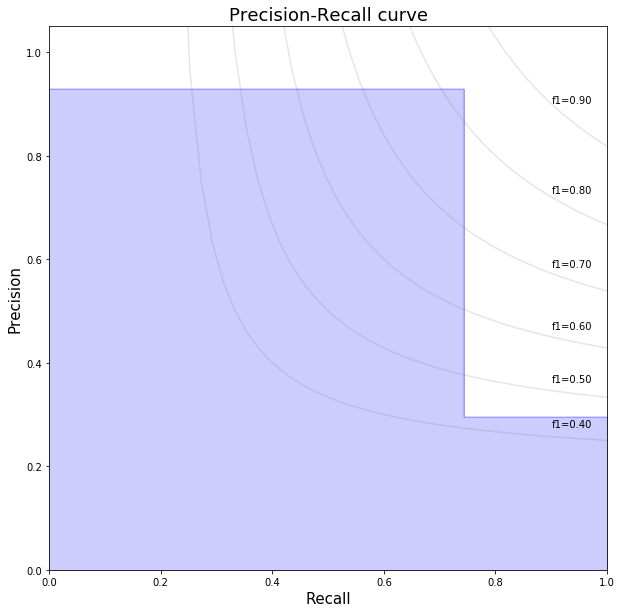

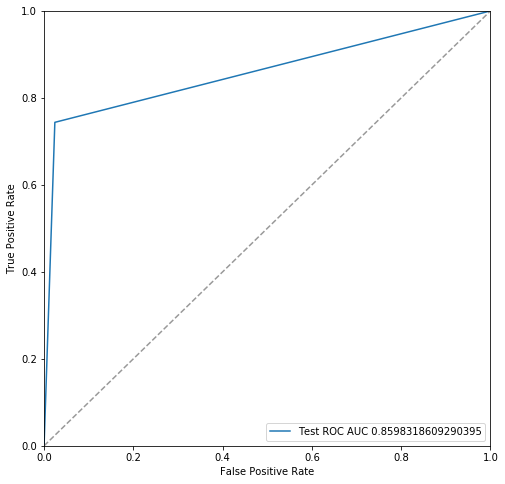

In [63]:
plot_precision_recall_curve(pred_rf,valid_y)
roc_auc_pic(pred_rf,valid_y)

In [48]:
# confusion_matrix - Воспользуемся функцией построения матрицы ошибок из документации sklearn

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')


In [49]:
# font = {'size' : 15}

# plt.rc('font', **font)

# cnf_matrix = confusion_matrix(y_test, y_pred2)
# plt.figure(figsize=(10, 8))
# plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
#                       title='Confusion matrix')
# # plt.savefig("conf_matrix.png")
# plt.show()

In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, pred_rf)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2))

Confusion matrix

 [[283   7]
 [ 31  90]]

True Positives(TP) =  283

True Negatives(TN) =  90

False Positives(FP) =  7

False Negatives(FN) =  31
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       147
           1       0.23      0.34      0.28        59

    accuracy                           0.49       206
   macro avg       0.45      0.45      0.44       206
weighted avg       0.55      0.49      0.51       206



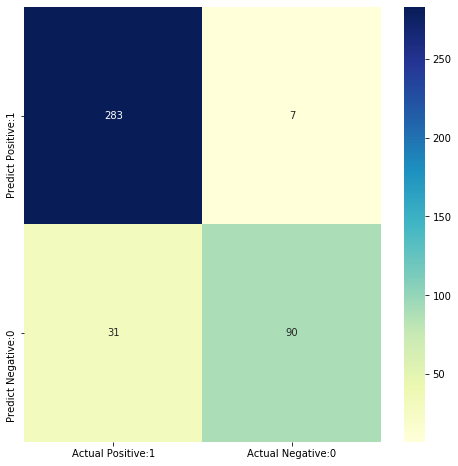

In [65]:
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [52]:
# from sklearn.model_selection import cross_validate # подгрузили модель

# model = lgb.LGBMClassifier()
# scores = cross_validate(model,feature_df,clean_df['checked_churn'],cv = 5,scoring = ('roc_auc'),return_train_score = True)
# scores

# КОНЕЦ

### вопросы:

    1. нужно ли нормализовать данные перед отправкой на кластеризацию - с ней качество кластеризации падает
    2. нормальная ли логика проверки адекватности кластеризации - проверить по silhouette и сравнить roc_aucом с наивными лейблами 
    3. можно ли сказать,что алгоритм был заинмствован 
    4. rule-based не работает , потому что он накидывался на ручные лейблы
    5. какой алгоритм lightgbm верный?

### как продолжать работу:

    1.upd_EDA project 

       V унифицировать картинки + отсортировать по убыванию
       - ??? проработать emoji
       - поиск твитов по неделям
    
    2. clustering 
        
       V кумулятивный tfidf - поставил критерий max_feature
       V  добавить text_len и topic ,fact,sin_time	cos_time в кластериазцию
       V добавить метрики кластеризации
                попробовать разбиения с разными расстояниями и вывести лучшее по silhette score
                сравнить разбиения с разными расстояниями против размеченных данных вручную
       ?V нормировать значения перед модельками
       V метод главных компонент для визуализации
       
    
    3. rule-based
        
        V добавить свои слова в поиск 10 слов
        V таргетировать churn по rule_based alg 
        V сохранить новый churn в clean_df и в файл
        
     4. classification
        V почитать про наивный байес
        V заменить модель на lightgbm 
         
     5. текст + презентация
         - текст + картинки + презентация (оставить 2-3 дня на это)

### Что доделать:
    0. какая lgb верная? + PCA
    V набрать больше данных
    2. исправить выводы исходя из новых данных
    3. указать даты данных
    V проверить результаты кластеризации и если что исправить код под новый тип кластеризации
    5. презентация исправить все что поменялось
    6. текст - исправить все,что поменялось 
    7   текст - выделено желтым 
    8  текст - дописать введение и заключение 
    9  текст - оформление+ список литры
    V  текст - подпись рисунков и таблиц
    11 презентация - слайд со временем
    


In [53]:
# Classification Models and Success metrics
  

  
# def model(classifier, train_vector, valid_vector,train_y,valid_y):
#     classifier.fit(train_vector, train_y)  
#     predict_y = classifier.predict(valid_vector)
#     accuracy = accuracy_score(valid_y, predict_y)
#     precision = precision_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
#     recall = recall_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
#     conf_matrix = confusion_matrix(valid_y, predict_y)
#     print('\nAccuracy_score: {:.3f}'.format(accuracy ))
#     print('precision_score: {:.3f}'.format(precision.mean()))
#     print('recall_score: {:.3f}'.format(recall.mean()))
#     print('roc_auc_score',roc_auc_score(valid_y, predict_y))
#     print('\nconfusion_matrix: \n')
    
#     print(confusion_matrix(valid_y, predict_y))
#     print(classification_report(valid_y, predict_y))
    
#     return roc_auc_pic(predict_y, valid_y),plot_precision_recall_curve(predict_y, valid_y)

# # roc_auc_pic

# def roc_auc_pic(y_hat_test, y_test):    
#     fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
#     roc_auc_test = roc_auc_score(y_test, y_hat_test)

#     plt.rcParams['figure.figsize'] = (8, 8)
#     plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
#     plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
#     plt.show() 
#     pass
# # roc_auc_pic(y_pred_lr, valid_y)


# # precision_recall

# def plot_precision_recall_curve(y_pred_proba, y_test):
#     plt.figure(figsize=(10, 10))
#     f_scores = np.linspace(0.4, 0.9, num=6)
#     lines = []
#     labels = []
#     for f_score in f_scores:
#         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
#     precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

#     plt.step(recall, precision, color='b', alpha=0.2, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.2,
#                      color='b')
#     plt.xlabel('Recall', size=15)
#     plt.ylabel('Precision', size=15)
#     plt.title('Precision-Recall curve', size=18)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.show()
# # plot_precision_recall_curve(y_pred_lr, valid_y)

In [54]:
# model(LogisticRegression(), norm_train_x, norm_valid_x,norm_train_y,norm_valid_y)
